In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import numpy as np
import random
import argparse
from keras.models import model_from_json, Model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
import tensorflow as tensor
# from keras.engine.training import collect_trainable_weights
import json
import control
from  control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import warnings
import random
import math



from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network_fullcycle import ActorNetwork
from DDPG_Critic_Network_fullcycle import CriticNetwork
from OU import OU
import timeit


iterations = []
tracking_error = []
total_reward = []

OU = OU()

class environment():

    def reset(self):
            self.next_error = random.uniform(0,5)
            self.kp = random.randrange(10,100)
            self.ki = random.randrange(10,100)
            self.kd = random.randrange(10,100)
            return self.next_error,self.kp, self.ki, self.kd
        

    def env(self ,a) :
            
            
            self.kp = a[0]
            self.ki = a[1]
            self.kd = a[2]

#             A = 0.00113
#             B = 0.0078854
#             C = 0.0171
#             D = 0.067

#    if self.sys_sel == 1:
#             Jl = 2.5*1e-3
#             Kt = 1
#         elif self.sys_sel == 2:
            Jl = 6.3*1e-3
            Kt = 1
#         elif self.sys_sel == 3:
#             Jl = 2.5*1e-3
#             Kt = 3
#         else:
#             Jl = 0
#             Kt = 0
#             print('\tError! system 1~3 is available for now!')
#             quit()
        # constant
            Jm = 6.329*1e-4
            Tsigma = 1.1*1e-5
            Tsigman = 1.25*1e-4
            B = 3.0*1e-4
            Ksf = (60*1)/(2500*5*1e-3)
            amplitude = 2000
            # sample period: 100us
            T_period = []
            T_ini = 0
            for _ in range(5000):
                T_period.append(T_ini)
                T_ini += 100*1e-6

            '''
            speed loop
            Yspeed(s)/W(s) = B1*kd*s^2 + B1*kp*s + B1*ki / A1*s^3 + (B1*kd+A2)*s^2 + (A3+B1*kp)*s + B1*ki
            '''
            A1 = (Jm + Jl) * Tsigman
            A2 = B * Tsigman + (Jm + Jl)
            A3 = B
            B1 = Kt * Ksf
#             self.kp = action[0]
#             self.ki = action[1]
    #         self.kd = action[2]
            # speed loop feedback lti system 
    #         speed_fb_lti = scipy.signal.lti([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            # Angular velocity: Xt
#             speed_fb_lti = scipy.signal.lti([B1*self.kp, B1*self.ki], [A1, A2, A3+B1*self.kp, B1*self.ki])

            feedback_sys = tf([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            
            y, t = step(feedback_sys)
#             print("y", y)
            error = 1-y
            absolute_error = np.absolute(error)
            iae = np.sum(absolute_error)
            itae  = np.sum(absolute_error*t)
            ise = np.sum(np.square(error))
            itse = np.sum(t*np.square(error))
            last_error = self.next_error
            self.next_error = iae
#             tracking_error.append(iae)
#             self.next_error = 11 - iae 
            reward  = 1/(1 + abs(self.next_error)) - 1/(1 + abs(last_error))
#             reward  = math.exp(pow(((0.9 * abs(itae))), 2)/ (-2) * pow(10, 2))
#             plt.plot(t,y)
#             plt.grid()
# and itae == 170.95 and ise == 4.786 and itse == 30.373
            total_reward.append(reward)
            done = False
            if self.next_error <1.0001   :
                done = True
            tracking_error.append(self.next_error) 
            return self.next_error, reward, done
        

PID = environment()

def play():
    
    BUFFER_SIZE = 100000
    BATCH_SIZE = 50
    GAMMA = 0.99
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0001    #Learning rate for Actor
    LRC = 0.001 
    action_size = 3
    action_dim = 3
    state_dim  = 1
    np.random.seed(1337)
    
    vision = False
    EXPLORE = 100000.
    episode_count = 10000
    max_steps = 1000
    reward = 0
    done = False
    step = 0
    epsilon = 1
    indicator = 0
    train_indicator = 1
    
    config = tensor.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tensor.Session(config=config)
    from keras import backend as K
    K.set_session(sess)
    
    actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
    critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
    buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
    for i in range(episode_count):
        print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
        total_reward = 0.
        state,kp,ki,kd = PID.reset()
#         print("reset_error", state)

        
        for j in range(max_steps):
            
            loss = 0
            epsilon  -= 1.0/ EXPLORE
            a_t = np.zeros([1, action_size])
            noise_t = np.zeros([1, action_size])
            
            a_t_original = actor.model.predict(np.array([state]))
            print("a_t_original: ", a_t_original)
            noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0], 2 , 0.0001, 0.0001)
            noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1], 2 , 0.0001, 0.0001)
            noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.0001, 0.0001)
            
            a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
            a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
            a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
            print("a_t", a_t[0])
            next_state, reward, done  = PID.env(a_t[0])
            print("error",next_state)
            buff.add(state, a_t[0], reward, next_state, done)   
            batch = buff.getBatch(BATCH_SIZE)
            states = np.asarray([e[0] for e in batch])
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            next_states = np.asarray([e[3] for e in batch])
            dones = np.asarray([e[4] for e in batch])
            y_t = np.asarray([e[1] for e in batch])
            target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
            if (train_indicator):
                loss += critic.model.train_on_batch([(states),actions], y_t) 
#                 print("loss",loss)
                a_for_grad = actor.model.predict(states)
                if buff.count() <= BATCH_SIZE:
                    K= buff.count()
                else:
                    K = BATCH_SIZE
                states = states.reshape(K,1)
                grads = critic.gradients(states, a_for_grad)

                actor.train(states, grads)
                actor.target_train()
                critic.target_train()
                
            
            state = next_state
#             total_reward += reward
#             print("total_reward", reward)
            if j == 999:
                iterations.append(j)
            
            if done:
                iterations.append(j)
                break 
            
                
if __name__ == "__main__":
    play()
warnings.filterwarnings("ignore")








Episode : 0 Replay Buffer 0
a_t_original:  [[0.51347834 0.46589527 0.49057156]]
a_t [0.51351716 0.46586706 0.4908703 ]
error 1.0254651406944055
a_t_original:  [[0.5091682  0.48075178 0.49636334]]
a_t [0.50936515 0.48084411 0.49642588]
error 1.0251222017452388
a_t_original:  [[0.51064175 0.4803926  0.4981265 ]]
a_t [0.51079026 0.48075216 0.49824342]
error 1.0250335906073724
a_t_original:  [[0.51205426 0.48007852 0.4999454 ]]
a_t [0.51207995 0.48024536 0.4999544 ]
error 1.02495131154526
a_t_original:  [[0.5134594  0.47978362 0.50183034]]
a_t [0.51356717 0.47997878 0.50197127]
error 1.0248537057037328
a_t_original:  [[0.51487887 0.47946888 0.50370574]]
a_t [0.51508179 0.47998491 0.50399465]
error 1.0247558387660831
a_t_original:  [[0.51618505 0.4790844  0.50563294]]
a_t [0.51630235 0.47914382 0.5057272 ]
error 1.0246738508761157
a_t_original:  [[0.51736236 0.4784988  0.50748104]]
a_t [0.51749426 0.47859066 0.50774635]
error 1.0245770995955539
a_t_original:  [[0.5184382  0.47753906 0.50908

a_t_original:  [[0.4477625  0.34776697 0.4861823 ]]
a_t [0.44785694 0.34785655 0.48614773]
error 1.0256971105758725
a_t_original:  [[0.44571677 0.3460733  0.48450068]]
a_t [0.4459109  0.34619446 0.48466629]
error 1.0257742387580921
a_t_original:  [[0.44364765 0.34436378 0.4827969 ]]
a_t [0.44383149 0.34448629 0.48299511]
error 1.0258618724040747
a_t_original:  [[0.4415781  0.34265324 0.48111385]]
a_t [0.44172815 0.34278621 0.48117895]
error 1.0259581240636333
a_t_original:  [[0.43949097 0.34092993 0.47942057]]
a_t [0.43978352 0.34096341 0.47944462]
error 1.0260515952495544
a_t_original:  [[0.43738747 0.33920068 0.477709  ]]
a_t [0.437577   0.33931437 0.47798746]
error 1.026128468062574
a_t_original:  [[0.43529296 0.33747733 0.47599918]]
a_t [0.43556496 0.3375108  0.47600298]
error 1.0262371538997543
a_t_original:  [[0.4332289  0.33575773 0.4743047 ]]
a_t [0.43348379 0.33586631 0.47460497]
error 1.0263121163273223
a_t_original:  [[0.4311999  0.3340003  0.47265622]]
a_t [0.4313817  0.334

a_t_original:  [[0.27460626 0.2266356  0.30690274]]
a_t [0.2746788  0.22692003 0.30699923]
error 1.0404954272979867
a_t_original:  [[0.27298298 0.22647385 0.30472583]]
a_t [0.27325856 0.22688193 0.30488394]
error 1.0407670711916754
a_t_original:  [[0.27138105 0.22640151 0.30258375]]
a_t [0.27159628 0.22646858 0.3027229 ]
error 1.0410492551738106
a_t_original:  [[0.2697996  0.22641136 0.3004751 ]]
a_t [0.26989135 0.22644619 0.30059125]
error 1.0413339388926144
a_t_original:  [[0.2682465  0.22650614 0.29841176]]
a_t [0.26844818 0.22676636 0.2985907 ]
error 1.041605178798928
a_t_original:  [[0.26672724 0.2266908  0.29640025]]
a_t [0.26695103 0.22694262 0.29661459]
error 1.0418743995913615
a_t_original:  [[0.2652401  0.22695762 0.29443535]]
a_t [0.26535778 0.22718986 0.29439751]
error 1.04217886240024
a_t_original:  [[0.26377526 0.22729492 0.29250485]]
a_t [0.26397284 0.22748932 0.29272808]
error 1.042407755461284
a_t_original:  [[0.26234785 0.22771744 0.2906223 ]]
a_t [0.26273081 0.227918

a_t_original:  [[0.21591698 0.35751066 0.21430834]]
a_t [0.21618405 0.35776388 0.21449525]
error 1.0574118640928007
a_t_original:  [[0.215918   0.36046094 0.21385065]]
a_t [0.21621465 0.36061741 0.21404799]
error 1.0575323057302923
a_t_original:  [[0.21595234 0.3634073  0.21342552]]
a_t [0.21614919 0.36359407 0.21364584]
error 1.0576339982867826
a_t_original:  [[0.21604644 0.36629215 0.21304406]]
a_t [0.21618634 0.36655875 0.21338082]
error 1.057696371643264
a_t_original:  [[0.21617846 0.36916763 0.21270053]]
a_t [0.21632026 0.36924594 0.21271998]
error 1.0578680582078939
a_t_original:  [[0.21631943 0.37203076 0.21236731]]
a_t [0.21645675 0.37205666 0.21259187]
error 1.0578846038714216
a_t_original:  [[0.21651545 0.3748971  0.21208778]]
a_t [0.21651685 0.37496    0.21223979]
error 1.057971057691807
a_t_original:  [[0.21672796 0.3777419  0.21182258]]
a_t [0.21687187 0.37774402 0.2119315 ]
error 1.058049166928535
a_t_original:  [[0.21696782 0.3805682  0.21158193]]
a_t [0.21711263 0.38072

error 1.0528437122622714
a_t_original:  [[0.25132146 0.46976382 0.23312987]]
a_t [0.25158662 0.4700176  0.2333441 ]
error 1.05270497599677
a_t_original:  [[0.25243887 0.46929306 0.23375973]]
a_t [0.2525675  0.46951272 0.23397626]
error 1.0525878663325638
a_t_original:  [[0.25356153 0.46880767 0.23438297]]
a_t [0.25359502 0.46882856 0.23459686]
error 1.0524709194466326
a_t_original:  [[0.2546866  0.46830657 0.23500086]]
a_t [0.25510235 0.46830664 0.2351222 ]
error 1.0523791337727526
a_t_original:  [[0.25580662 0.46778727 0.23560768]]
a_t [0.25588196 0.46782391 0.23582139]
error 1.0522344964263521
a_t_original:  [[0.25693217 0.46725148 0.23621511]]
a_t [0.25692023 0.46720748 0.23641228]
error 1.0521225471561673
a_t_original:  [[0.258049   0.46669877 0.23680861]]
a_t [0.25826292 0.46673953 0.23706793]
error 1.0519912078439977
a_t_original:  [[0.25916657 0.4661438  0.2373981 ]]
a_t [0.25937544 0.46629089 0.2376221 ]
error 1.0518747928704812
a_t_original:  [[0.2602801  0.46558288 0.2379791 

a_t_original:  [[0.32908353 0.41108572 0.25038117]]
a_t [0.32923941 0.41136183 0.25052247]
error 1.0496743836370777
a_t_original:  [[0.32997838 0.4101205  0.25019786]]
a_t [0.33007634 0.4101986  0.250426  ]
error 1.049692101076419
a_t_original:  [[0.33087516 0.40916386 0.25001335]]
a_t [0.33108031 0.409226   0.2499445 ]
error 1.0497950171707653
a_t_original:  [[0.33176255 0.4082039  0.24980798]]
a_t [0.33197028 0.40834752 0.24996153]
error 1.049802038489812
a_t_original:  [[0.3326625  0.40725192 0.24961157]]
a_t [0.33261384 0.40752159 0.2498384 ]
error 1.0498457902481186
a_t_original:  [[0.33355823 0.40629536 0.24940214]]
a_t [0.33367218 0.40659969 0.24949575]
error 1.0499476477050895
a_t_original:  [[0.33444634 0.4053309  0.24917631]]
a_t [0.3346047  0.40534475 0.24934991]
error 1.049999334942122
a_t_original:  [[0.3353389  0.4043698  0.24895363]]
a_t [0.33552263 0.40453306 0.24933744]
error 1.0500181309097767
a_t_original:  [[0.3362369  0.40340665 0.2487314 ]]
a_t [0.33656626 0.40361

a_t_original:  [[0.39364508 0.33428788 0.22858997]]
a_t [0.39383895 0.33444037 0.22871698]
error 1.0559918278017029
a_t_original:  [[0.39436322 0.33297527 0.22832894]]
a_t [0.39450598 0.33307704 0.22837137]
error 1.056110843620821
a_t_original:  [[0.39507467 0.33165956 0.2280824 ]]
a_t [0.39511136 0.33200967 0.22817664]
error 1.0561843200141068
a_t_original:  [[0.39577895 0.33034042 0.22785535]]
a_t [0.39577345 0.33056028 0.22794406]
error 1.0562754480974386
a_t_original:  [[0.39647055 0.32901365 0.22763509]]
a_t [0.39673613 0.32921214 0.22791105]
error 1.0563141296339413
a_t_original:  [[0.39715564 0.32769617 0.22743769]]
a_t [0.3972617  0.32774763 0.22747605]
error 1.0564558576936576
a_t_original:  [[0.3978222  0.32635856 0.22723188]]
a_t [0.39809194 0.32642782 0.22727478]
error 1.0565351991763412
a_t_original:  [[0.39848462 0.32502815 0.22705343]]
a_t [0.39878514 0.32522042 0.22721474]
error 1.0565775214283737
a_t_original:  [[0.3991449  0.32371107 0.22690424]]
a_t [0.39919969 0.323

a_t_original:  [[0.40564    0.26386398 0.27234903]]
a_t [0.40570303 0.264005   0.27255115]
error 1.0472791716809402
a_t_original:  [[0.40522426 0.26347563 0.27361578]]
a_t [0.40530295 0.26371891 0.27380809]
error 1.0470382678929713
a_t_original:  [[0.4048016  0.2630834  0.27489007]]
a_t [0.40512964 0.26331146 0.27517083]
error 1.0467870212889758
a_t_original:  [[0.40439168 0.26273903 0.27612546]]
a_t [0.40437318 0.26294798 0.276434  ]
error 1.0465425307627543
a_t_original:  [[0.40399307 0.26243874 0.2773254 ]]
a_t [0.40411939 0.26267712 0.27766047]
error 1.046316685463638
a_t_original:  [[0.40360823 0.26217496 0.2784853 ]]
a_t [0.40384408 0.26247471 0.27861408]
error 1.0461414196363175
a_t_original:  [[0.4032327  0.26194128 0.27960625]]
a_t [0.40348957 0.26223743 0.27987508]
error 1.045911432303687
a_t_original:  [[0.4028774  0.26174808 0.28069997]]
a_t [0.40294791 0.26187539 0.28098343]
error 1.0457148717050588
a_t_original:  [[0.40253696 0.26157692 0.28175178]]
a_t [0.40263159 0.2618

KeyboardInterrupt: 

In [ ]:
[8.27e-5 ,1.5936e-5 ,.00000001]
a = [0 ,0 ,0]


PID.env(a)

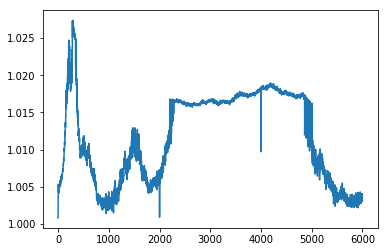

In [6]:
plt.plot(np.arange(6000), error_values[4000:10000])
plt.show()